# Prediction of oat yields in Poland based on temperature and precipitation during its growth.

### Introduction
In this notebook we’ve created a Bayesian regression model to predict yields of oat in Poland, in a given year, based on monthly average temperature, and precipitation during the time of its growth. The point of creating this model is being able to predict the approximate yields before the time of harvest, which can be useful for planning the agricultural economy (how much are we able to sell, etc). Having that information even one month before the harvest could be crucial.

We've decided to choose this topic due to the increasingly changing rainfall patterns, longer dry periods, and quite low soil quality, which are unfavorable for most agricultural crops. Oat on the other hand can withstand harsher conditions, and in our opinion is underutilized in Polish agriculture.

Yield of oat depends on plenty of factors, such as type of the oat, soil fertility, fertilization, sowing density, agrotechnical treatments, and weather conditions. We are aware that it’s impossible for us to accurately predict yields on a specific field purely based on the weather. That’s why we are considering yields of a whole country to average all of the other factors as much as possible, getting a model for an average farm.

### Data sources
The oat yield data comes from the public GUS data, which contains the yearly average oat yields in Poland ranging only from 2010 (it’s fine, because the most recent technological changes made older data somewhat redundant). It contains oat yields measured by dt/ha (decitons per hectare). This unit is very important because it doesn’t measure the total mass of our yields, but rather the efficiency of the fields (size of the fields doesn’t matter).

The weather data comes from the public IMGW data. We decided to use data from 2013 to 2023. Provided csv files contain monthly precipitation (mm), or monthly average temperature (°C) for each measuring station (precipitation and temperature data came in separate files). Each provided csv file contained data for only one year, which required a lot of preprocessing.

Note: in this project we also used two small, complete datasets, contained in the literature we used for our project. We only used that data for testing priors, because it comes from special experimental fields (belonging to University of Life Sciences in Poznań, and ZD UNG Sadłowice). These fields were kept in perfect conditions during the research, which made the yields far better than of an average field in Poland.


### Data preprocessing
First, we parsed the weather data for each year by averaging precipitation and temperature of all of the measuring stations for each month (since we want to predict yields for the whole country). Then we merged precipitation and temperature data, and discarded all of the irrelevant months, only considering the period of oat growth (from April to July). Finally, we combined all of the chosen years (2013 to 2023), and merged with yearly yield data. The created table was exported to a new csv file.

In [ ]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("oat_data_1.csv")
df = df.drop(["pIV-VII", "tIV-VII"], axis=1)
df.to_csv("oat_data_1_2.csv", index=False)

In [3]:
paths = ["oat_data_1_2.csv", "oat_data_2.csv", "oat_data_3.csv"]
data = []

for path in paths:
    data.append(pd.read_csv(path))

data.append(pd.concat(data, ignore_index=True))
data

[   year   pIV    pV    pVI   pVII  tIV    tV   tVI  tVII  yields
 0  1985  21.5  46.8   59.5   24.5  7.5  14.9  14.3  18.0   41.40
 1  1986  32.6  53.3   83.7   56.8  7.4  14.7  16.2  18.0   58.80
 2  1987  28.0  26.0   82.3  111.3  8.0  10.9  15.0  17.1   57.40
 3  1988  28.9  23.3  151.5  103.3  8.0  15.4  16.5  18.7   30.70
 4  1989  25.9   8.8   47.5   75.9  8.7  14.5  16.1  18.4   37.10
 5  1990  49.9  21.8  109.1   45.6  8.0  14.3  16.5  17.0   52.80
 6  1994  47.5  66.4   34.3   63.5  9.1  12.0  15.2  21.9   43.08
 7  1995  12.0  77.6   89.1   16.3  8.2  12.7  16.0  21.0   56.11
 8  1996  13.8  74.2   33.8  216.2  8.3  12.7  16.4  15.8   50.25
 9  1997  39.9  67.6   47.4  177.4  5.5  12.9  17.0  18.0   58.25,
    year        pIV          pV         pVI        pVII        tIV         tV  \
 0  2013  34.756809   99.279384  123.914134   55.178108   7.349045  13.457325   
 1  2014  45.257158  109.534402   66.359402   90.897430   9.035669  12.496815   
 2  2015  31.000926   54.43173

In [4]:
for i in range(3):
    print(data[i].describe())


              year        pIV         pV         pVI        pVII        tIV  \
count    10.000000  10.000000  10.000000   10.000000   10.000000  10.000000   
mean   1990.700000  30.000000  46.580000   73.820000   89.080000   7.870000   
std       4.423423  12.857078  24.970774   37.179917   64.879303   0.973025   
min    1985.000000  12.000000   8.800000   33.800000   16.300000   5.500000   
25%    1987.250000  22.600000  23.975000   47.425000   48.400000   7.625000   
50%    1989.500000  28.450000  50.050000   70.900000   69.700000   8.000000   
75%    1994.750000  38.075000  67.300000   87.750000  109.300000   8.275000   
max    1997.000000  49.900000  77.600000  151.500000  216.200000   9.100000   

              tV        tVI       tVII     yields  
count  10.000000  10.000000  10.000000  10.000000  
mean   13.500000  15.920000  18.390000  48.589000  
std     1.464392   0.828385   1.825407   9.923789  
min    10.900000  14.300000  15.800000  30.700000  
25%    12.700000  15.400000 

### Model 1

Our first model is based on the regression provided in the article "EFFECT OF WEATHER CONDITIONS ON OATS YIELDS" by T. Michalski, R. Idziak, and L. Menzel. The authors came to conclusion that oat yields depend on precipitation in June, and average temperature in May. They came up with the following regression for aproximating the yields:

$$
Y = 41.43 - 0.109\cdot{t_V^2} + 0.764\cdot{O_{VI}} - 0.00433\cdot{O_{VI}^2}
$$

where Y - yields, t - temperature, O - precipitation

We based our model on the regression above, adjusting its parameters. We've decided to use the normal distribution, because we can asume that given the same weather conditions, we can expect similar yields, offset by other dependencies we are not considering.

$$Y\sim{Normal(a - b\cdot{t_V^2} + c\cdot{O_{VI}} - d\cdot{O_{VI}^2}, \sigma)}$$

$$a\sim{Normal(41.43, \sigma_a)}$$

$$b\sim{Normal(0.109, \sigma_b)}$$

$$c\sim{Normal(0.764, \sigma_c)}$$

$$d\sim{Normal(0.00433, \sigma_d)}$$


#### Priors

Our priors were different than the ones in the regression above (TODO: DOKOŃĆZ i dlaczego)

In [5]:
model_prior = CmdStanModel(stan_file='oat_yield_prior.stan')
R = 1000

INFO:cmdstanpy:found newer exe file, not recompiling


In [6]:
sims = []
N= []
for i,d in enumerate(data):
    N.append(len(d))
    sim = model_prior.sample(
        data=dict(N=N[i], 
                  precipitation_june=d["pVI"],
                    average_temperature_may=d["tV"]),
        iter_sampling=R,
        iter_warmup=1,
        chains=1,
        fixed_param=True,
        seed=42,
        refresh=R
    )
    yields_pred_prior = sim.stan_variable("yields")
    yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)
    sims.append(sim)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


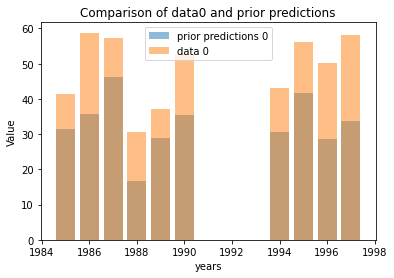

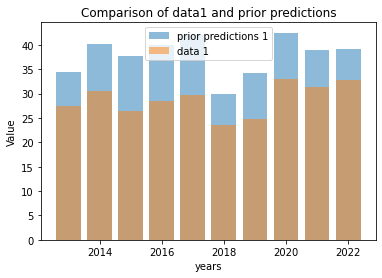

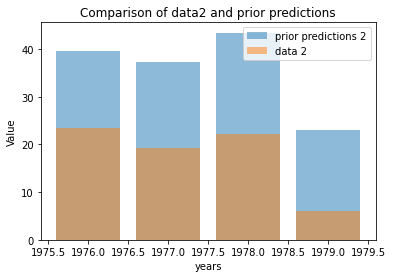

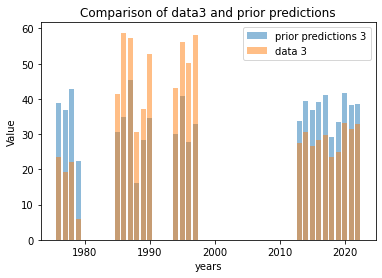

In [7]:
for i,d in enumerate(data):
    yields_pred_prior = sims[i].stan_variable("yields")
    yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

    plt.bar(list(d["year"]), yields_pred_prior_means, alpha=0.5)
    plt.bar(list(d["year"]), list(d["yields"]), alpha=0.5)
    plt.legend([f"prior predictions {i}", f"data {i}"])
    plt.xlabel('year')
    plt.ylabel('Value') 
    plt.title(f'Comparison of data{i} and prior predictions') 
    plt.show()

#### Posterior

In [8]:
model_posterior = CmdStanModel(stan_file='oat_yield_posterior.stan')


INFO:cmdstanpy:found newer exe file, not recompiling


In [9]:
fits = []
for i,d in enumerate(data):
    fit = model_posterior.sample(data=dict(N=N[i], precipitation_june=d["pVI"], average_temperature_may=d["tV"], yields=d["yields"]), seed=42)
    fits.append(fit)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed

chain 3 |██████████| 00:02 Sampling completed
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)



chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████ | 00:03 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |█████████▌| 00:03 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:03 Sampling completed      

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)




chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███████▎  | 00:04 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |███████▋  | 00:04 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |████████▏ | 00:05 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:05 Iteration: 1700 / 2000 [ 85%]  (Sampling)


INFO:cmdstanpy:CmdStan done processing.


[ 5.82274577 -7.48209023  4.45371638  0.85923948  7.7712514  -2.06228318
  3.6161032   1.26232673 -5.67740192 -8.6072762 ]


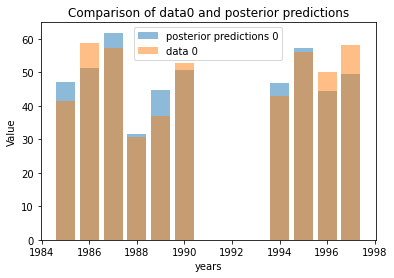

[-0.46889057 -0.12993105  1.75676897  2.09492055  2.31424443 -0.46592225
  0.50815928 -0.4388489  -2.20238762 -2.97118595]


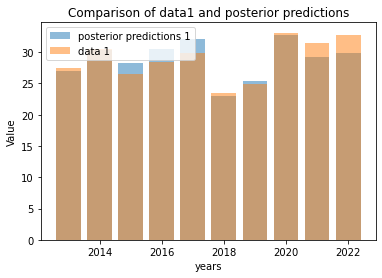

[-1.34037063 -1.112819    1.70065235  0.7808552 ]


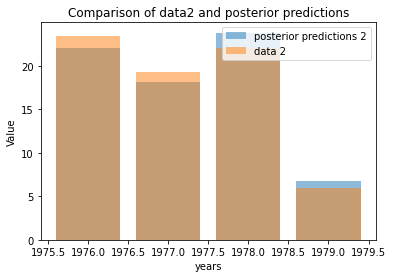

[ -4.98608323 -19.34430117 -18.99668905   0.65649485  -3.60349285
 -13.61189392 -14.1846079  -16.904413   -21.3687227  -25.20749428
   9.83933858   6.43505425   6.55510412   9.9236271    9.29516582
  13.46288812   5.48548823   3.1423116    2.1170774    4.6964015
  11.54611053  17.14316962  15.39204127  22.5639632 ]


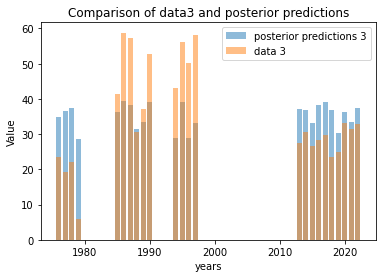

In [10]:
for i,d in enumerate(data):
    yields_pred_posterior = fits[i].stan_variable("yields_pred")
    yields_pred_posterior_means = np.mean(yields_pred_posterior, axis=0)
    print(yields_pred_posterior_means-list(d["yields"]))
    plt.bar(list(d["year"]), yields_pred_posterior_means, alpha=0.5)
    plt.bar(list(d["year"]), list(d["yields"]), alpha=0.5)
    plt.legend([f"posterior predictions {i}", f"data {i}"])
    plt.xlabel('years')
    plt.ylabel('Value') 
    plt.title(f'Comparison of data{i} and posterior predictions') 
    plt.show()

In [11]:
a = [0] * len(data)
b = [0] * len(data)
c = [0] * len(data)
d = [0] * len(data)
for i in range (len(data)):
    a[i] = np.mean(fits[i].stan_variable("a"))
    b[i] = np.mean(fits[i].stan_variable("b"))
    c[i] = np.mean(fits[i].stan_variable("c"))
    d[i] = np.mean(fits[i].stan_variable("d"))
    print(f"a{i}: " + str(a[i]))
    print(f"b{i}: " + str(b[i]))
    print(f"c{i}: " + str(c[i]))
    print(f"d{i}: "+ str(d[i]))
    print()

a0: 41.21795135
b0: 0.1089058813
c0: 0.76609276175
d0: 0.004350633035

a1: 17.02171507
b1: 0.0767547309
c1: 0.60089827225
d1: 0.0033000086299999998

a2: 15.87767611145
b2: 0.13113316004999997
c2: 0.70332897325
d2: 0.0048980867925

a3: 12.721009727499998
b3: -0.01000424050298
c3: 0.52384968325
d3: 0.00274818483



### Model 2

In the second model we tried to include weather data from every single relevant month as parameters. TODO

#### Priors

In [12]:
model_prior2 = CmdStanModel(stan_file='oat_yield_prior_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [13]:
R = 1000
sims2 = []
N = []
for i,d in enumerate(data):
    N.append(len(d))
    dict = {
        "N": N[i],
        "precipitation_april": d["pIV"],
        "precipitation_may": d["pV"],
        "precipitation_june": d["pVI"],
        "precipitation_july": d["pVII"],
        "average_temperature_april": d["tIV"],
        "average_temperature_may": d["tV"],
        "average_temperature_june": d["tVI"],
        "average_temperature_july": d["tVII"]
    }
    sim=model_prior2.sample( data=dict,
                        iter_sampling=R,
                        iter_warmup=1,
                        chains=1,
                        fixed_param=True,
                        seed=42,refresh=R)
    
    yields_pred_prior = sim.stan_variable("yields")
    yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)


   
    sims2.append(sim)


INFO:cmdstanpy:CmdStan start processing


chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


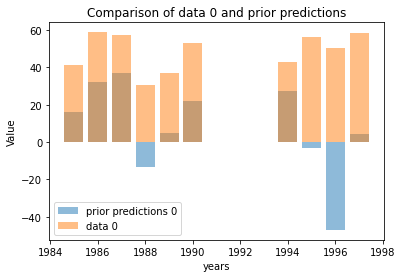

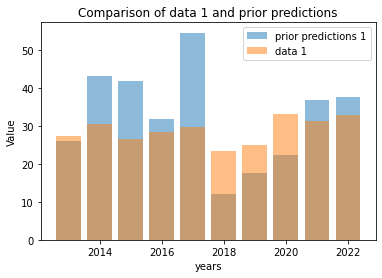

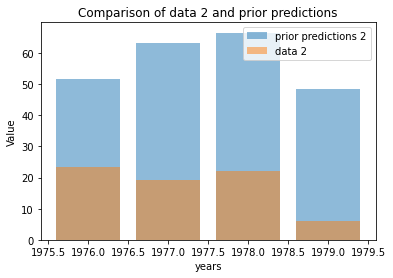

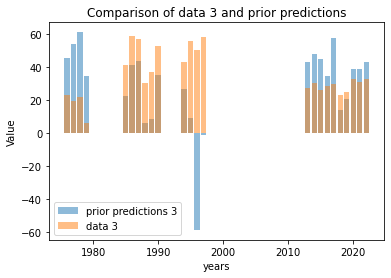

In [14]:
for i,d in enumerate(data):
    yields_pred_prior = sims2[i].stan_variable("yields")
    yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

    plt.bar(list(d["year"]), yields_pred_prior_means, alpha=0.5)
    plt.bar(list(d["year"]), list(d["yields"]), alpha=0.5)
    plt.legend([f"prior predictions {i}", f"data {i}"])
    plt.xlabel('years')
    plt.ylabel('Value') 
    plt.title(f'Comparison of data {i} and prior predictions') 
    plt.show()

#### Posterior

In [15]:
model_posterior2 = CmdStanModel(stan_file='oat_yield_posterior_2.stan')



INFO:cmdstanpy:found newer exe file, not recompiling


In [16]:
fits2 = []
for i,d in enumerate(data):
    dict = {
        "N": N[i],
        "precipitation_april": d["pIV"],
        "precipitation_may": d["pV"],
        "precipitation_june": d["pVI"],
        "precipitation_july": d["pVII"],
        "average_temperature_april": d["tIV"],
        "average_temperature_may": d["tV"],
        "average_temperature_june": d["tVI"],
        "average_temperature_july": d["tVII"],
        "yields": d["yields"]
    }

    fit2 = model_posterior2.sample(data=dict, seed=42)
    fits2.append(fit2)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:04 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:05 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:06 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:07 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:10 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:12 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:13 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:14 Iteration: 1400 / 2000 [ 70%]  (Sampling)




chain 1 |████████▏ | 00:16 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:05 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:06 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:07 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:09 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:11 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:12 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:13 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:14 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |███████▋  | 00:16 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:17 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:02 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:03 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:03 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:04 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:05 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:06 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:07 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:08 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:10 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:11 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:12 Iteration: 1300 / 2000 [ 65%]  (Samp


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▋       | 00:03 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:04 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:06 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:07 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:11 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:12 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:15 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:17 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:19 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:21 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:23 Iteration: 1500 / 2000 [ 75%]  (Sampli


INFO:cmdstanpy:CmdStan done processing.


[ 0.07103678 -0.00229617  0.01428845  0.04029697 -0.01049342 -0.04313547
  0.00024382 -0.0085422  -0.017323    0.05526685]


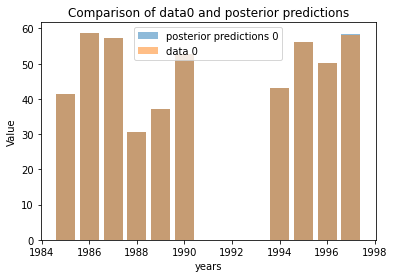

[ 0.0541194  -0.03041062  0.19613388  0.07014005  0.05388573 -0.0719906
  0.0657608  -0.03459305 -0.13942742 -0.1048249 ]


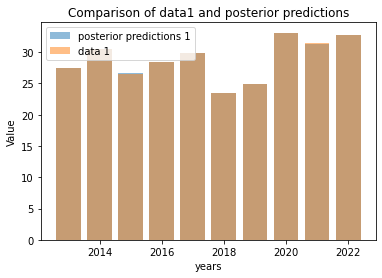

[-0.06364717 -0.07701355  0.05546135  0.01206257]


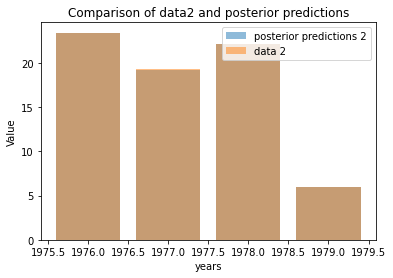

[  1.6134015  -19.23981845 -12.494227     5.36659063   7.62077238
 -13.43378092 -11.5442235    2.5689859    1.93680682  -8.93803645
   3.47820147   0.58526725   7.11866417  11.27623605  -2.02867415
   5.58774552  -6.35162228  -0.75871965   5.67100825   7.2334533
   6.9523993    3.49310057   7.92616742  -3.43697914]


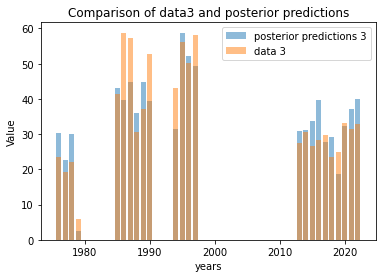

In [17]:
for i,d in enumerate(data):
    yields_pred_posterior = fits2[i].stan_variable("yields_pred")
    yields_pred_posterior_means = np.mean(yields_pred_posterior, axis=0)
   
    plt.bar(list(d["year"]), yields_pred_posterior_means, alpha=0.5)
    plt.bar(list(d["year"]), list(d["yields"]), alpha=0.5)
    print(yields_pred_posterior_means-list(d["yields"]))
    plt.legend([f"posterior predictions {i}", f"data {i}"])
    plt.xlabel('years')
    plt.ylabel('Value') 
    plt.title(f'Comparison of data{i} and posterior predictions') 
    plt.show()

In [18]:
a = [0] * len(data)
b = [0] * len(data)
c = [0] * len(data)
d = [0] * len(data)
for i in range (len(data)):
    a[i] = np.mean(fits2[i].stan_variable("a"))
    b[i] = np.mean(fits2[i].stan_variable("b"), axis=0)
    c[i] = np.mean(fits2[i].stan_variable("c"), axis=0)
    d[i] = np.mean(fits2[i].stan_variable("d"), axis=0)

    print(f"Data: {i}")
    print("a: " + str(a[i]))
    print()
    for j in range(4):
        print(f"b[{j}]: " + str(b[i][j]))
        print(f"c[{j}]: " + str(c[i][j]))
        print(f"d[{j}]: " + str(d[i][j]))
        print()
    print()

Data: 0
a: 24.67367099775

b[0]: -0.016791793457975
c[0]: 0.33363773315125
d[0]: 0.0035734442796199993

b[1]: 0.10593486576026752
c[1]: 0.20235258992237748
d[1]: -0.001906152588111

b[2]: -0.11762268822175
c[2]: 0.6477397825035001
d[2]: 0.0036132658483

b[3]: 0.1015653418
c[3]: 0.16180846611289998
d[3]: 0.0010052920563824999


Data: 1
a: 20.810733249749997

b[0]: 0.067243429675575
c[0]: 0.074356682259175
d[0]: 0.00191692982474025

b[1]: 0.034903634614605
c[1]: -0.484251983484
d[1]: -0.0033017460542750002

b[2]: -0.0034249459906024998
c[2]: -0.15319253915527503
d[2]: -0.0013696792057537501

b[3]: 0.027369441379521
c[3]: 0.9247010340824999
d[3]: 0.004343159854182501


Data: 2
a: 24.8767192365

b[0]: 0.068298244938425
c[0]: 0.5366938952324999
d[0]: 0.0054665133829075

b[1]: 0.10806351087046
c[1]: 0.633158722458
d[1]: 0.00440227221519

b[2]: 0.16721983903425003
c[2]: 0.49131859349535
d[2]: 0.0070400319696625

b[3]: 0.00018439472255000022
c[3]: 0.763445964345
d[3]: 0.0033549319854639997


D

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:1635: UserWarning: For one 

<AxesSubplot:xlabel='Deviance'>

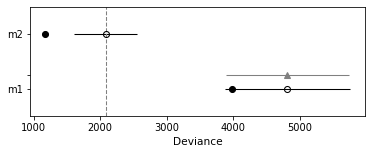

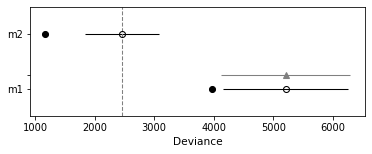

In [19]:
comp_dict = {"m1":fits[len(data)-1], "m2": fits2[len(data)-1]}
comp_loo = az.compare(comp_dict, ic="loo",scale="deviance")
az.plot_compare(comp_loo)
comp_waic = az.compare(comp_dict, ic="waic",scale="deviance")
az.plot_compare(comp_waic)


Model 3 (z liczbą dni z opadami)

In [3]:
df = pd.read_csv("weather_data_2010_2020.csv")

filtered_data = df[(df['Year'] >= 2013) & (df['Month'].isin(['april', 'may', 'june', 'july']))]
pivot_data = filtered_data.pivot(index='Year', columns='Month', values='Rainy Days')
pivot_data = pivot_data[['april', 'may', 'june', 'july']]
pivot_data.reset_index(inplace=True)
pivot_data.columns.name = None
pivot_data.to_csv("filtered_weather_data.csv", index=False)
print(pivot_data)

   Year  april  may  june  july
0  2013     11   20    18     9
1  2014     16   18    16    14
2  2015     12   16    10    13
3  2016     14   16     7    21
4  2017     17   11    15    18
5  2018      8   12    15    22
6  2019      6   20    12    19
7  2020      3   17    21    20


In [6]:
df_2 = pd.read_csv("oat_data_2.csv")
filtered_data_2 = df_2[(df_2['year'] <= 2020)]
filtered_data_2.loc[:,'pIV'] = filtered_data_2['pIV'].values/30*pivot_data['april'].values
filtered_data_2.loc[:,'pV'] = filtered_data_2['pV'].values/31*pivot_data['may'].values
filtered_data_2.loc[:,'pVI'] = filtered_data_2['pVI'].values/30*pivot_data['june'].values
filtered_data_2.loc[:,'pVII'] = filtered_data_2['pVII'].values/31*pivot_data['july'].values
print(filtered_data_2)

/tmp/ipykernel_414/3976432105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_2.loc[:,'pIV'] = filtered_data_2['pIV'].values/30*pivot_data['april'].values
/tmp/ipykernel_414/3976432105.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_2.loc[:,'pV'] = filtered_data_2['pV'].values/31*pivot_data['may'].values
/tmp/ipykernel_414/3976432105.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

   year        pIV         pV        pVI       pVII        tIV         tV  \
0  2013  12.744163  64.051215  74.348480  16.019451   7.349045  13.457325   
1  2014  24.137151  63.600620  35.391681  41.050452   9.035669  12.496815   
2  2015  12.400370  28.093798  16.263622  28.449147   6.907527  11.548387   
3  2016  19.779054  28.337841  17.641064  89.419465   8.014474  13.055263   
4  2017  43.033462  18.407476  43.739895  66.743687   6.263014  12.616438   
5  2018   8.117995  19.927295  30.862609  76.397637  11.971831  15.518310   
6  2019   5.006480  64.876475  15.695772  35.996064   8.604478  11.494030   
7  2020   0.946711  45.462025  87.653624  42.085696   7.603175  10.120635   

         tVI       tVII  yields  
0  16.721019  18.097452    27.4  
1  15.121019  19.316883    30.5  
2  15.343011  18.600000    26.5  
3  17.172000  17.902703    28.4  
4  16.793151  17.191781    29.8  
5  17.323944  18.787324    23.5  
6  20.212121  17.531818    24.9  
7  17.198413  17.620635    33.1  


In [7]:
filtered_data_2.describe()

,year,pIV,pV,pVI,pVII,tIV,tV,tVI,tVII,yields
count,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,2016.50000,15.770673,41.594593,40.199593,49.520200,8.218651,12.538400,16.985585,18.131074,28.012500
std,2.44949,13.331084,20.391508,27.315918,25.318533,1.757556,1.599807,1.553188,0.718322,3.119724
min,2013.00000,0.946711,18.407476,15.695772,16.019451,6.263014,10.120635,15.121019,17.191781,23.500000
25%,2014.75000,7.340116,26.052172,17.296704,34.109335,7.238665,11.534798,16.376517,17.598431,26.100000
50%,2016.50000,12.572267,36.899933,33.127145,41.568074,7.808824,12.556627,16.982575,18.000077,27.900000
75%,2018.25000,20.868578,63.713269,51.392041,69.157174,8.712275,13.155779,17.229795,18.646831,29.975000
max,2020.00000,43.033462,64.876475,87.653624,89.419465,11.971831,15.518310,20.212121,19.316883,33.100000


In [14]:
model_prior_3 = CmdStanModel(stan_file='oat_yield_prior_3.stan')
R = 1000

INFO:cmdstanpy:compiling stan file /root/Data-Analitics-Project/project/project/oat_yield_prior_3.stan to exe file /root/Data-Analitics-Project/project/project/oat_yield_prior_3


INFO:cmdstanpy:compiled model executable: /root/Data-Analitics-Project/project/project/oat_yield_prior_3


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


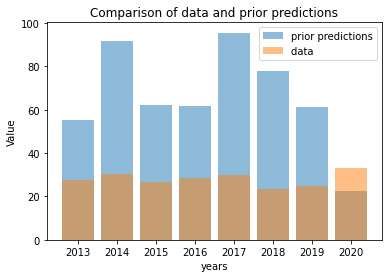

In [15]:
N = len(filtered_data_2)
dict = {
    "N": N,
    "precipitation_june": filtered_data_2["pVI"],
    "average_temperature_may": filtered_data_2["tV"]
}
sim_3 = model_prior_3.sample(data=dict,
                    iter_sampling=R,
                    iter_warmup=1,
                    chains=1,
                    fixed_param=True,
                    seed=42,refresh=R)

yields_pred_prior = sim_3.stan_variable("yields")
yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

plt.bar(list(filtered_data_2["year"]), yields_pred_prior_means, alpha=0.5)
plt.bar(list(filtered_data_2["year"]), list(filtered_data_2["yields"]), alpha=0.5)
plt.legend(["prior predictions", "data "])
plt.xlabel('years')
plt.ylabel('Value') 
plt.title(f'Comparison of data and prior predictions') 
plt.show()

In [16]:
model_posterior_3 = CmdStanModel(stan_file='oat_yield_posterior_3.stan')

INFO:cmdstanpy:compiling stan file /root/Data-Analitics-Project/project/project/oat_yield_posterior_3.stan to exe file /root/Data-Analitics-Project/project/project/oat_yield_posterior_3


INFO:cmdstanpy:compiled model executable: /root/Data-Analitics-Project/project/project/oat_yield_posterior_3


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.



[ 1.46883067 -0.86637022  0.69494827 -3.2010294   0.643554    0.01975045
  2.26684098 -1.1387322 ]


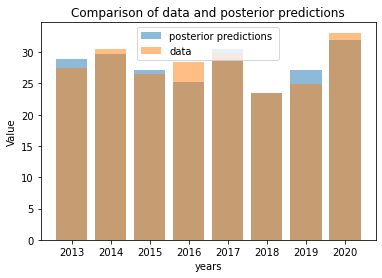

In [17]:
dict = {
    "N": N,
    "precipitation_june": filtered_data_2["pVI"],
    "average_temperature_may": filtered_data_2["tV"],
    "yields": filtered_data_2["yields"]
}

fit_3 = model_posterior_3.sample(data=dict, seed=42)
yields_pred_posterior = fit_3.stan_variable("yields_pred")
yields_pred_posterior_means = np.mean(yields_pred_posterior, axis=0)

plt.bar(list(filtered_data_2["year"]), yields_pred_posterior_means, alpha=0.5)
plt.bar(list(filtered_data_2["year"]), list(filtered_data_2["yields"]), alpha=0.5)
print(yields_pred_posterior_means-list(filtered_data_2["yields"]))
plt.legend(["posterior predictions ", "data"])
plt.xlabel('years')
plt.ylabel('Value') 
plt.title('Comparison of data and posterior predictions') 
plt.show()

In [18]:
a = np.mean(fit_3.stan_variable("a"))
b = np.mean(fit_3.stan_variable("b"))
c = np.mean(fit_3.stan_variable("c"))
d = np.mean(fit_3.stan_variable("d"))
print("a: " + str(a))
print("b: " + str(b))
print("c: " + str(c))
print("d: "+ str(d))

a: 30.6345667
b: 0.063985045725
c: 0.36560480284999997
d: 0.0031434060278249997


Model 4 (model 3 dla wszystkich miesięcy)


In [19]:
model_prior_4 = CmdStanModel(stan_file='oat_yield_prior_4.stan')
R = 1000

INFO:cmdstanpy:compiling stan file /root/Data-Analitics-Project/project/project/oat_yield_prior_4.stan to exe file /root/Data-Analitics-Project/project/project/oat_yield_prior_4
INFO:cmdstanpy:compiled model executable: /root/Data-Analitics-Project/project/project/oat_yield_prior_4


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


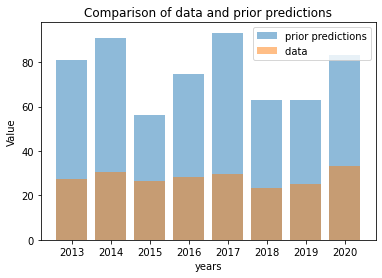

In [21]:
dict = {
    "N": N,
    "precipitation_april": filtered_data_2["pIV"],
    "precipitation_may": filtered_data_2["pV"],
    "precipitation_june": filtered_data_2["pVI"],
    "precipitation_july": filtered_data_2["pVII"],
    "average_temperature_april": filtered_data_2["tIV"],
    "average_temperature_may": filtered_data_2["tV"],
    "average_temperature_june": filtered_data_2["tVI"],
    "average_temperature_july": filtered_data_2["tVII"]
}

sim_4=model_prior_4.sample( data=dict,
                    iter_sampling=R,
                    iter_warmup=1,
                    chains=1,
                    fixed_param=True,
                    seed=42,refresh=R)
yields_pred_prior = sim_4.stan_variable("yields")
yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

plt.bar(list(filtered_data_2["year"]), yields_pred_prior_means, alpha=0.5)
plt.bar(list(filtered_data_2["year"]), list(filtered_data_2["yields"]), alpha=0.5)
plt.legend(["prior predictions", "data "])
plt.xlabel('years')
plt.ylabel('Value') 
plt.title(f'Comparison of data and prior predictions') 
plt.show()

In [22]:
model_posterior_4 = CmdStanModel(stan_file='oat_yield_posterior_4.stan')

INFO:cmdstanpy:compiling stan file /root/Data-Analitics-Project/project/project/oat_yield_posterior_4.stan to exe file /root/Data-Analitics-Project/project/project/oat_yield_posterior_4


INFO:cmdstanpy:compiled model executable: /root/Data-Analitics-Project/project/project/oat_yield_posterior_4


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)




chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)




chain 1 |████████▋ | 00:03 Iteration: 1600 / 2000 [ 80%]  (Sampling)



chain 1 |█████████ | 00:03 Iteration: 1700 / 2000 [ 85%]  (Sampling)




chain 1 |█████████▌| 00:03 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 


INFO:cmdstanpy:CmdStan done processing.



[-0.32019477  0.31113015 -0.13176173 -0.35017737  0.13212497  0.12906142
  0.07708915  0.13221002]


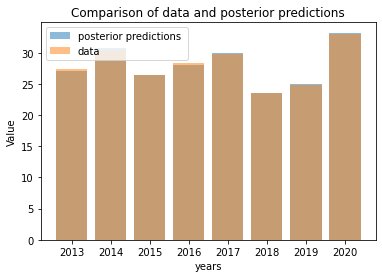

In [23]:
dict = {
    "N": N,
    "precipitation_april": filtered_data_2["pIV"],
    "precipitation_may": filtered_data_2["pV"],
    "precipitation_june": filtered_data_2["pVI"],
    "precipitation_july": filtered_data_2["pVII"],
    "average_temperature_april": filtered_data_2["tIV"],
    "average_temperature_may": filtered_data_2["tV"],
    "average_temperature_june": filtered_data_2["tVI"],
    "average_temperature_july": filtered_data_2["tVII"],
    "yields": filtered_data_2["yields"]
}

fit_4 = model_posterior_4.sample(data=dict, seed=42)
yields_pred_posterior = fit_4.stan_variable("yields_pred")
yields_pred_posterior_means = np.mean(yields_pred_posterior, axis=0)

plt.bar(list(filtered_data_2["year"]), yields_pred_posterior_means, alpha=0.5)
plt.bar(list(filtered_data_2["year"]), list(filtered_data_2["yields"]), alpha=0.5)
print(yields_pred_posterior_means-list(filtered_data_2["yields"]))
plt.legend(["posterior predictions ", "data"])
plt.xlabel('years')
plt.ylabel('Value') 
plt.title('Comparison of data and posterior predictions') 
plt.show()

In [24]:
a = np.mean(fit_4.stan_variable("a"))
b = np.mean(fit_4.stan_variable("b"), axis=0)
c = np.mean(fit_4.stan_variable("c"), axis=0)
d = np.mean(fit_4.stan_variable("d"), axis=0)

print("a: " + str(a))
print()
for j in range(4):
    print(f"b[{j}]: " + str(b[j]))
    print(f"c[{j}]: " + str(c[j]))
    print(f"d[{j}]: " + str(d[j]))
    print()

a: 26.00326253225

b[0]: 0.07743233454875
c[0]: 0.0285486642582025
d[0]: 0.004498607377499999

b[1]: 0.007043125226725
c[1]: 0.470046706
d[1]: 0.0044931008175

b[2]: 0.030131962808325
c[2]: 0.45448789225
d[2]: 0.004173468557250001

b[3]: 0.044055240213475004
c[3]: 0.5204324215
d[3]: 0.00382358245



Porównanie

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:1635: UserWarning: For one 

<AxesSubplot:xlabel='Deviance'>

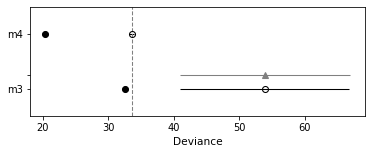

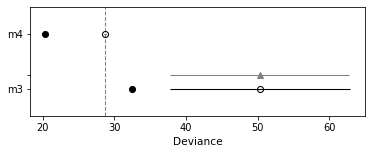

In [25]:
comp_dict = {"m3":fit_3, "m4": fit_4}
comp_loo = az.compare(comp_dict, ic="loo",scale="deviance")
az.plot_compare(comp_loo)
comp_waic = az.compare(comp_dict, ic="waic",scale="deviance")
az.plot_compare(comp_waic)